## Hovmoller Sites NDVI

This notebook opens a shape file of transects, allows you to select a transect by number, and plot a hovmoller diagram of the site NDVI based on datacube landsat surface reflectance data and BoM rainfall data.

* if the time period is changed, you will need to re-save the data manually by changing 'savepath' so that files are not overwritten
* you will need to change coordinate reference system specs if the shapefile is not in Albers.
* rainfall data is currently in WGS84 due to datacube issues. This isn't a problem at the moment but could be later.
* if running for a time period where one of the sensors is not available, you may need to comment out statements referring to that sensor

Dependencies:

  * shapefile of the site transects in EPSG 3577/Australian Albers
  
  
The following sensors are available for the following time frames:
* Landsat 5 - 1986 to April 1999  followed by a gap until May 2003 - November 2011 (data from 2009 onwards becomes less reliable in southern Australia)
* Landsat 7 - April 1999 to present, however after May 2003 the scan line corrector (SLC) failed, 
so data are referred to as SLC-off, meaning they've got a venetian blinds appearance with wedges of missing data
  * This data is not well suited for inclusion in composites, but is fine to use in time series analysis
* Landsat 8 - April 2013 onwards
  
Bex Dunn april 2017

Changelog:
August 2017 - working on: changes to text and colors, removing tsm from plot for publication.

In [2]:
#in this notebook we want to plot non-interactively
%matplotlib inline

#get a bunch of modules to use

#suppress warnings thrown when rainfall data is imported
import logging
logging.getLogger('rasterio._gdal').setLevel(logging.ERROR)
import warnings

import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
import datetime as dt

import matplotlib as mpl
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
# import json
import pandas as pd
# from IPython.display import display
# import ipywidgets as widgets

from shapely.geometry import shape
import matplotlib.gridspec as gridspec
import numpy as np
import pickle
import os
import geopandas as gpd

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser as pq_fuser
from datacube.storage.masking import mask_valid_data as mask_invalid_data
import rasterio
#tells the datacube what app you are planning on using
dc = datacube.Datacube(app='dc-BOMRainfallandNbar')

### Set up functions for this notebook

In [3]:
#This defines the function that converts a linear vector file into a string of x,y coordinates
def geom_query(geom, geom_crs='EPSG:3577'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }

def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    gets the transect
    """
    #Changed for py3 compatibility 17.03.17
    dist = [i for i in range(0, int(geom.length), resolution)]
    #points = zip(*[geom.interpolate(d).coords[0] for d in dist]) py2
    points = list(zip(*[geom.interpolate(d).coords[0] for d in dist])) #py3
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)

## add the path to the input shapefile

In [5]:
#transects file will be the file containing our transects
transects_file = '/g/data1/r78/rjd547/groundwater_activities/GalileeBasin/shapefiles/GAL_landsat_traverses_v2.shp'
transects_df = gpd.read_file(transects_file)

## Define the epoch

In [6]:
#Define temporal range
start_of_epoch = '1987-10-01' 
end_of_epoch =  '2016-10-01'
print ('temporal range is '+start_of_epoch+' to '+end_of_epoch)

temporal range is 1987-10-01 to 2016-10-01


### Set up wavelengths/bands/sensors/TSS and brightness adjustments

In [7]:
#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'swir2'
                     ]

#Define sensors of interest
sensor1 = 'ls5'
sensor2 = 'ls7'
sensor3 = 'ls8'

# #Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
# pq_albers_product = dc.index.products.get_by_name(sensor1+'_pq_albers')
# valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

#load sensor specific band adjustment tuples for TSS and brightness
brightness_coeff = {}
brightness_coeff['ls5'] = (0.304, 0.279, 0.434, 0.559, 0.508, 0.186)
brightness_coeff['ls7'] = (0.304, 0.279, 0.434, 0.559, 0.508, 0.186)
brightness_coeff['ls8'] = (0.3029, 0.2786, 0.4733, 0.5599, 0.508, 0.1872)

greenness_coeff = {}
greenness_coeff['ls5'] = (-0.285, -0.244, -0.544, 0.724, 0.084, -0.180)
greenness_coeff['ls7'] = (-0.285, -0.244, -0.544, 0.724, 0.084, -0.180)
greenness_coeff['ls8'] = (-0.2941, -0.243, -0.5424, 0.7276, 0.0713, -0.1608)

wetness_coeff = {}
wetness_coeff['ls5'] = (0.151, 0.179, 0.330, 0.341, -0.711, -0.457)
wetness_coeff['ls7'] = (0.151, 0.179, 0.330, 0.341, -0.711, -0.457)
wetness_coeff['ls8'] = (0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559)

Have a look at the dataframe of transects below to decide which one to plot

In [9]:
transects_df
#________________we want:________________#
#Doongmabulla Springs 1 [0],Mellaluka Springs across Belyando River[3], 

,age,descript,geometry,length,name
0,None,Mouldy Crumpet to Joshua spring Nth Sth transect,LINESTRING (333152.1150188967 -2378106.4247318...,0.0,Doongmabulla Springs 1
1,None,Mouldy Crumpet to House springs across Carmich...,LINESTRING (331915.9228778984 -2377393.2795609...,0.0,Doongmabulla Springs 2
2,None,Carmichael river crossection just downstream o...,LINESTRING (359123.2453407632 -2381555.6643693...,0.0,Carmichael River floodplain
3,None,Mellaluka Springs across Belyando River,LINESTRING (354186.8214257854 -2403744.4131395...,0.0,Mellaluca Springs
4,None,Transect downstream of Carmicahael River,LINESTRING (375250.3853521309 -2351340.9583175...,0.0,Belyando River 2
5,None,"Across Clematis outcrop, Carmichael River and ...",LINESTRING (338736.0563474478 -2379204.1335882...,0.0,Doongmabulla Springs 5
6,None,Albro springs - SW node 44,LINESTRING (352591.3145249395 -2439795.7923115...,0.0,Albro springs - SW model node 44
7,None,Moses to Wobbly Springs transect,LINESTRING (333109.981444028 -2377582.48023976...,0.0,Doongmabulla Springs 3
8,None,Transect down Carmichael River in Doongmabulla...,LINESTRING (330440.2444942251 -2374398.7934021...,0.0,Carmichael River transect


### loop over transects, pull in rainfall and nbar from datacube and output hovmoller plots

choose the index of the transect you would like to plot:0
Doongmabulla Springs 1 : Mouldy Crumpet to Joshua spring Nth Sth transect
Doongmabulla_Springs_1_ix0
loaded bom rainfall grids from datacube
saved rainfall data to file
loaded sensor1 NBAR and PQ from datacube
loaded sensor2 NBAR and PQ from datacube
loaded sensor3 NBAR and PQ from datacube
saved sensor NBAR and PQ data to file


/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


/g/data/r78/rjd547/groundwater_activities/GalileeBasin/pickledata/Doongmabulla_Springs_1_ix0_/



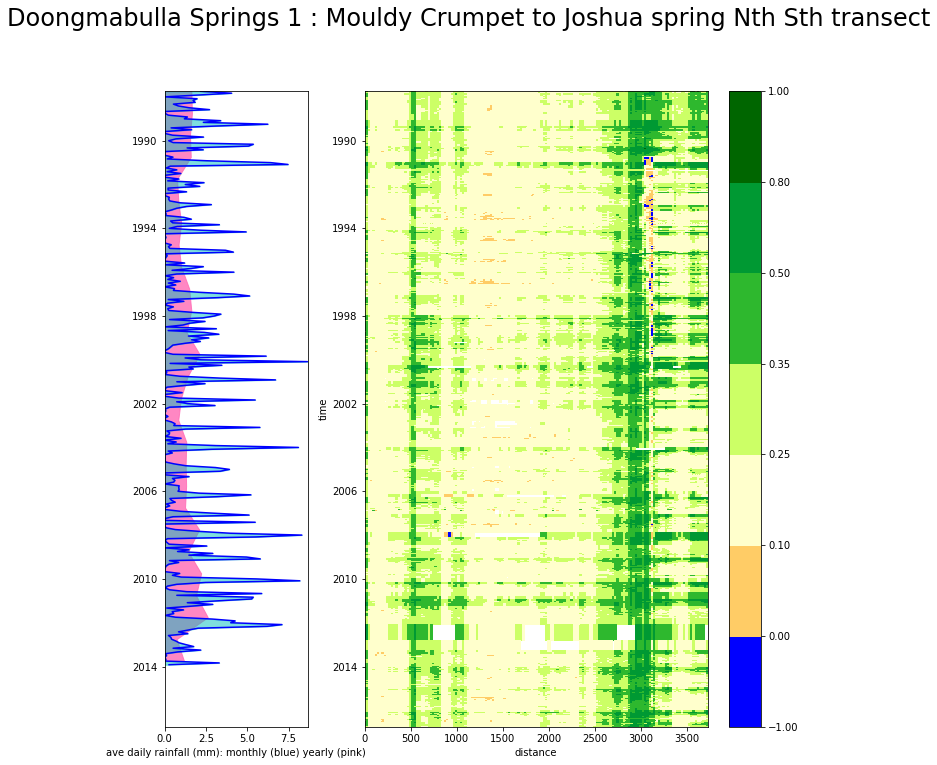

In [30]:
#use fiona module to open the shape file
transects = fiona.open(transects_file)
while True:
    #this statement asks you to choose a shapefile. put in a number and press enter.
    i = int(input("choose the index of the transect you would like to plot:"))
    #for i in range(len(transects)):
    geom = shape(transects[i]['geometry'])
    query = {
        'time': (start_of_epoch, end_of_epoch),
    }
    query.update(geom_query(geom, geom_crs=transects.crs_wkt)) #comment this out if not using a polygon

    #use the transect dataframe to get transect metadata
    transect_index = transects_df.index[i]
    transect_name = transects_df['name'][i] 
    if transects_df['descript'][i] is not None:
        transect_description = transects_df['descript'][i]
    else:
        transect_description = ' '
    try:
        print(transect_name+' : '+transect_description)
    except TypeError as err:
        print("TypeError: {0}".format(err))
        print(transect_name)

    #create a filename for the transect
    shape_name = transect_name.split()
    shape_name ='_'.join(shape_name)
    shape_name=shape_name+'_ix'+str(transect_index)
    print(shape_name)

    #setup a save directory for our data
    savepath ='/g/data/r78/rjd547/groundwater_activities/GalileeBasin/pickledata/'+shape_name+'_/'
    try:
            os.mkdir(savepath)
    except OSError as err:
            print("OS error: {0}".format(err))
    try:
        #try to get the rain data from a pickle file saved earlier 
        f = open(savepath+'Rainfall_data'+'.pkl', 'rb')
        rain = pickle.load(f)
        Studysite_rain = rain['Studysite_rain']
        print('loaded rainfall grids from file:'+savepath+'Rainfall_data.pkl')
        f.close()
    except FileNotFoundError:
        #Grab bom_rainfall_grids from the datacube
        print('loaded bom rainfall grids from datacube')
        Studysite_rain = dc.load(product = 'bom_rainfall_grids', **query)
        #make a dictionary of the data we want to save
        vars2pickle = {'Studysite_rain':Studysite_rain}
        f = open(savepath+'Rainfall_data'+'.pkl', 'wb')
        pickle.dump(vars2pickle,f) 
        print('saved rainfall data to file')
        #pickle.dump(vars2pickle,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
        f.close()   

    #resample xarray Dataset Studysite_rain by Annual'AS' to get yearly avg with year starting in october
    #Note that the resampling we did means that each year is labelled according to its first day  
    rain_sp = Studysite_rain.mean(dim = ('latitude','longitude'))
    month_sp = rain_sp.resample('MS', dim = 'time', how = 'mean')
    year_avg = Studysite_rain.resample('AS-OCT', dim='time', how='mean', keep_attrs=True)
    # Create a spatial average
    year_avg_sp = year_avg.mean(dim = ('latitude', 'longitude'))

    try:
        #try to get the NBAR and PQ data for sensor n from a pickle file saved earlier
        f = open(savepath+'NBARPQ_data'+'.pkl', 'rb')
        NBPQdata = pickle.load(f)
        sensor1_nbar = NBPQdata['sensor1_nbar']
        sensor1_pq = NBPQdata['sensor1_pq']
        sensor2_nbar = NBPQdata['sensor2_nbar']
        sensor2_pq = NBPQdata['sensor2_pq']
        sensor3_nbar = NBPQdata['sensor3_nbar']
        sensor3_pq = NBPQdata['sensor3_pq']
        print('loaded sensor NBAR and PQ from file')
        f.close()
    except FileNotFoundError:
        #Retrieve the NBAR and PQ data for sensor n from the datacube
        sensor1_nbar = dc.load(product= sensor1+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
        sensor1_pq = dc.load(product= sensor1+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)        
        print('loaded sensor1 NBAR and PQ from datacube')

        sensor2_nbar = dc.load(product= sensor2+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
        sensor2_pq = dc.load(product= sensor2+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  
        print('loaded sensor2 NBAR and PQ from datacube')

        sensor3_nbar = dc.load(product= sensor3+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
        sensor3_pq = dc.load(product= sensor3+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  
        print('loaded sensor3 NBAR and PQ from datacube')

        #make a dictionary of the data we want to save
        pickle_vars = {'sensor1_nbar':sensor1_nbar,'sensor1_pq':sensor1_pq,
                  'sensor2_nbar':sensor2_nbar,'sensor2_pq':sensor2_pq,
                  'sensor3_nbar':sensor3_nbar,'sensor3_pq':sensor3_pq}

        f = open(savepath+'NBARPQ_data'+'.pkl', 'wb')
        pickle.dump(pickle_vars,f) 
        print('saved sensor NBAR and PQ data to file')
        #pickle.dump(pickle_vars,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
        f.close()

    #save attributes
    crs = sensor1_nbar.crs
    crswkt = sensor1_nbar.crs.wkt
    affine = sensor1_nbar.affine

    s1_cloud_free = masking.make_mask(sensor1_pq, 
                                  cloud_acca='no_cloud',
                                  cloud_shadow_acca = 'no_cloud_shadow',
                                  cloud_shadow_fmask = 'no_cloud_shadow',
                                  cloud_fmask='no_cloud',
                                  blue_saturated = False,
                                  green_saturated = False,
                                  red_saturated = False,
                                  nir_saturated = False,
                                  swir1_saturated = False,
                                  swir2_saturated = False,
                                  contiguous=True)
    s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor1_nbar = sensor1_nbar.where(s1_good_data)
    sensor1_nbar.attrs['crs'] = crs
    sensor1_nbar.attrs['affine'] = affine

    s2_cloud_free = masking.make_mask(sensor2_pq, 
                                  cloud_acca='no_cloud',
                                  cloud_shadow_acca = 'no_cloud_shadow',
                                  cloud_shadow_fmask = 'no_cloud_shadow',
                                  cloud_fmask='no_cloud',
                                  blue_saturated = False,
                                  green_saturated = False,
                                  red_saturated = False,
                                  nir_saturated = False,
                                  swir1_saturated = False,
                                  swir2_saturated = False,
                                  contiguous=True)
    s2_good_data = s2_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor2_nbar = sensor2_nbar.where(s2_good_data)
    sensor2_nbar.attrs['crs'] = crs
    sensor2_nbar.attrs['affine'] = affine

    s3_cloud_free = masking.make_mask(sensor3_pq, 
                                  cloud_acca='no_cloud',
                                  cloud_shadow_acca = 'no_cloud_shadow',
                                  cloud_shadow_fmask = 'no_cloud_shadow',
                                  cloud_fmask='no_cloud',
                                  blue_saturated = False,
                                  green_saturated = False,
                                  red_saturated = False,
                                  nir_saturated = False,
                                  swir1_saturated = False,
                                  swir2_saturated = False,
                                  contiguous=True)
    s3_good_data = s3_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor3_nbar = sensor3_nbar.where(s3_good_data)
    sensor3_nbar.attrs['crs'] = crs
    sensor3_nbar.attrs['affine'] = affine

    #Set up some colour maps for the Hovmoller plots

    #This controls the colour map used for plotting NDVI
    ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
    ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
    ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
    
    #Retrieve the hovmoller data volumes and concatenate them

    geom_w = warp_geometry(geom, query['crs'], crs.wkt)
 
    hov_sensor1 = transect(sensor1_nbar, geom_w, 25)
    hov_sensor2 = transect(sensor2_nbar, geom_w, 25)
    hov_sensor3 = transect(sensor3_nbar, geom_w, 25)

    hov_multi = xr.concat([hov_sensor1, hov_sensor2, hov_sensor3], dim = 'time')
    time_sorted = hov_multi.time.argsort()
    hov_multi = hov_multi.isel(time=time_sorted)
  
    # Set the percentage of good data that you'd like to display with pernan variable 
    #- 0.9 will return rows that have 90% of valid values
    pernan = 0.8
    hov_multi = hov_multi.dropna('time',  thresh = int(pernan*hov_multi.distance.size))
  
    #calculate NDVI here
    hov_multi_ndvi = ((hov_multi.nir-hov_multi.red)/(hov_multi.nir+hov_multi.red))
    hov_multi_ndvi_drop = hov_multi_ndvi.dropna('time',  thresh = int(pernan*hov_multi.distance.size))
           
    #Make a hovmoller plot and save it to file.
    #Use firstyear and last year to zoom into periods of interest
    firstyearhov = start_of_epoch#'1987-06-01'
    lastyearhov = end_of_epoch #'2016-12-31'
    fig = plt.figure(figsize=(11.27,11.69))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
    ax1 = plt.subplot(gs[0, 0])
    ax1.plot(month_sp.rainfall, month_sp.time, color='b', alpha = 1)
    ax1.axes.set_xlabel('ave daily rainfall (mm): monthly (blue) yearly (pink)')
    
    #set up fill time as a datetime 64 object for matplotlib input
    #set up variables to plot the fill behind the yearly rain data
    filltime = (year_avg_sp.time.astype('datetime64'))
    zeros = np.zeros(shape=(len(filltime)))
    plt.fill_betweenx(filltime.time.values, zeros, year_avg_sp.rainfall, color ='hotpink', alpha = 0.8)
    #set up variables to plot the fill behind the months data
    mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
    plt.fill_betweenx(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 0.5)
    plt.axis([0, month_sp.rainfall.max(),lastyearhov , firstyearhov])
    
    ax2 = plt.subplot(gs[0, 1])
    hov_multi_ndvi_drop.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm)
 
    plt.axis([0, hov_multi_ndvi_drop.distance.max(), lastyearhov , firstyearhov])
    ax2.set_anchor("SE")

    plt.suptitle(transect_name+' : '+transect_description, fontsize ='24')

    #save the output files!
    plt.savefig(savepath+shape_name+'HovPlot'+'.png',bbox_inches='tight')

    print (savepath)
    
    #make a dictionary of the data we want to save
    vars2pickle = {'rain_sp':rain_sp, 
                   'month_sp':month_sp,
                   'hov_multi':hov_multi,
                   'hov_multi_ndvi_drop':hov_multi_ndvi_drop,
                   'ndvi_cmap': ndvi_cmap, 
                   'ndvi_norm': ndvi_norm, 
                   'savepath': savepath, 
                   'affine':affine}

    #save the dictionary into a pickle file
    f = open(savepath+'/Hov_plot_variables'+'.pkl', 'wb')
    pickle.dump(vars2pickle,f) 
    f.close()
    print()  
    break